In [1]:
import pandas as pd
import numpy as np
import json
from pandas import json_normalize
import pyarrow.parquet as pq
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_parquet('transaction_2021.parquet')
df2 = pd.read_parquet('transaction_2022.parquet')
df3 = pd.read_parquet('transaction_2023.parquet')

In [3]:
df_all = pd.concat([df, df2, df3])

# Data Preparation

In [5]:
#Drop some column
tns=df_all
tns=tns.drop(columns=['center','product_json'])

In [6]:
tns.head()

,payment_date,ent,total_amount,discount,paid_amount,trans_origin_type
0,2021-01-01 00:00:00.000,TCC43RQQZ3B,1627000.0,0.0,0,online
1,2021-01-01 00:00:00.000,TCC4Q4JZ4Q0,594000.0,0.0,0,online
2,2021-01-01 00:00:00.000,TCC4RJ11QE7,468000.0,0.0,0,online
3,2021-01-01 00:00:00.000,TCC434QRCJY,341000.0,0.0,0,online
4,2021-01-01 00:00:00.000,TCC43RRCE10,189000.0,0.0,0,online


In [7]:
#Change to Date format

tns['payment_date']=pd.to_datetime(tns['payment_date'])

# Create Features

In [9]:
#use data year 2021 to segment customer
tns1_6=tns[(tns['payment_date']>='2021-01-01') & (tns['payment_date']<='2021-06-30')]

In [10]:
#One Hot Encoding on Customer channel preference
one_hot_encoded = pd.get_dummies(tns1_6['trans_origin_type'], prefix='trans_type')
tns1_6 = pd.concat([tns1_6.iloc[:,:6], one_hot_encoded], axis=1)
tns1_6=tns1_6.drop(columns=['trans_origin_type'])

tns1_6.head()

,payment_date,ent,total_amount,discount,paid_amount,trans_type_offline,trans_type_online
0,2021-01-01,TCC43RQQZ3B,1627000.0,0.0,0,0,1
1,2021-01-01,TCC4Q4JZ4Q0,594000.0,0.0,0,0,1
2,2021-01-01,TCC4RJ11QE7,468000.0,0.0,0,0,1
3,2021-01-01,TCC434QRCJY,341000.0,0.0,0,0,1
4,2021-01-01,TCC43RRCE10,189000.0,0.0,0,0,1


In [12]:
tns1_6['Discount']=(1-(tns1_6['paid_amount']/tns1_6['total_amount']))*100

tns1_6.head()

,payment_date,ent,total_amount,discount,paid_amount,trans_type_offline,trans_type_online,Discount
0,2021-01-01,TCC43RQQZ3B,1627000.0,0.0,0,0,1,100.0
1,2021-01-01,TCC4Q4JZ4Q0,594000.0,0.0,0,0,1,100.0
2,2021-01-01,TCC4RJ11QE7,468000.0,0.0,0,0,1,100.0
3,2021-01-01,TCC434QRCJY,341000.0,0.0,0,0,1,100.0
4,2021-01-01,TCC43RRCE10,189000.0,0.0,0,0,1,100.0


In [13]:
#Total Spen by Customer
features=tns1_6.groupby('ent')['total_amount'].sum().reset_index()

features.head()

,ent,total_amount
0,8C4ECCCCC3Y,823000.0
1,8CCCCCC4R1F,3798000.0
2,BC11JW3U,4579000.0
3,BCCCCRE3CZY,410000.0
4,BCCCCREW3WY,2567500.0


In [14]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325627 entries, 0 to 325626
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ent           325627 non-null  object 
 1   total_amount  325627 non-null  float64
dtypes: float64(1), object(1)
memory usage: 5.0+ MB


In [15]:
tns1_6.groupby('ent')['paid_amount'].sum().reset_index()

,ent,paid_amount
0,8C4ECCCCC3Y,0
1,8CCCCCC4R1F,0
2,BC11JW3U,0
3,BCCCCRE3CZY,0
4,BCCCCREW3WY,0
...,...,...
325622,TZZZJ3WP,0
325623,TZZZJZ4Y,0
325624,TZZZREZF,0
325625,TZZZW417,0


In [16]:
features.head()

,ent,total_amount
0,8C4ECCCCC3Y,823000.0
1,8CCCCCC4R1F,3798000.0
2,BC11JW3U,4579000.0
3,BCCCCRE3CZY,410000.0
4,BCCCCREW3WY,2567500.0


In [23]:
# features=features.drop(columns=['paid_amount_x', 'paid_amount_y'])

In [17]:
tns1_6

,payment_date,ent,total_amount,discount,paid_amount,trans_type_offline,trans_type_online,Discount
0,2021-01-01,TCC43RQQZ3B,1627000.0,0.0,0,0,1,100.0
1,2021-01-01,TCC4Q4JZ4Q0,594000.0,0.0,0,0,1,100.0
2,2021-01-01,TCC4RJ11QE7,468000.0,0.0,0,0,1,100.0
3,2021-01-01,TCC434QRCJY,341000.0,0.0,0,0,1,100.0
4,2021-01-01,TCC43RRCE10,189000.0,0.0,0,0,1,100.0
...,...,...,...,...,...,...,...,...
1048570,2021-06-23,TCC4Q4ZWJZ7,1944000.0,189000.0,0,1,0,100.0
1048571,2021-06-23,TCCECQQ1CJI,1729000.0,189000.0,0,1,0,100.0
1048572,2021-06-23,TCC4Q3R1RJ2,1949000.0,191500.0,0,0,1,100.0
1048573,2021-06-23,TCCECQ4RR1I,1169000.0,0.0,0,0,1,100.0


In [18]:
#Frequency
features['frequency']=list(tns1_6.groupby('ent')['ent'].count())

#Aver Spend per Trans
features['Avg_spend']=features['total_amount']/features['frequency']

#Total Paid
features=features.merge(tns1_6.groupby('ent')['paid_amount'].sum().reset_index(), on='ent', how='left')

In [19]:
#Discount
features=features.merge(tns1_6.groupby('ent')['Discount'].mean().reset_index(), on='ent', how='left')

In [20]:
features.head()

,ent,total_amount,frequency,Avg_spend,paid_amount,Discount
0,8C4ECCCCC3Y,823000.0,2,4.115000e+05,0,100.0
1,8CCCCCC4R1F,3798000.0,2,1.899000e+06,0,100.0
2,BC11JW3U,4579000.0,11,4.162727e+05,0,100.0
3,BCCCCRE3CZY,410000.0,1,4.100000e+05,0,100.0
4,BCCCCREW3WY,2567500.0,3,8.558333e+05,0,100.0


In [21]:
#Actual Paid Ratio
#features['tot_disc']=100-((features['paid_amount']/features['total_amount'])*100)

#Start date
features['startdate']=list(tns1_6.groupby('ent')['payment_date'].min())

#Last date
features['lastdate']=list(tns1_6.groupby('ent')['payment_date'].max())
features['lastdate']=pd.to_datetime(features['lastdate'])

In [22]:
tns1_6.groupby('ent')['trans_type_online'].sum().reset_index()

,ent,trans_type_online
0,8C4ECCCCC3Y,1
1,8CCCCCC4R1F,2
2,BC11JW3U,3
3,BCCCCRE3CZY,0
4,BCCCCREW3WY,1
...,...,...
325622,TZZZJ3WP,5
325623,TZZZJZ4Y,0
325624,TZZZREZF,0
325625,TZZZW417,0


In [23]:
# Life time
features['total_time']=((features['lastdate']-features['startdate']).dt.days)+1

# MEAN TIME BETAWEEN PURCHASE
features['mtbp']=features['total_time']/features['frequency']


In [24]:
#Count offline
features=features.merge(tns1_6.groupby('ent')['trans_type_offline'].sum().reset_index(), on='ent', how='left')

#Count Online
features=features.merge(tns1_6.groupby('ent')['trans_type_online'].sum().reset_index(), on='ent', how='left')

In [25]:
# After clustering data, it turns out that these three factors were less important than other factos. 
features=features.drop(columns=['paid_amount', 'total_amount', 'total_time'])

In [26]:
features.head()

,ent,frequency,Avg_spend,Discount,startdate,lastdate,mtbp,trans_type_offline,trans_type_online
0,8C4ECCCCC3Y,2,4.115000e+05,100.0,2021-03-08,2021-05-03 08:39:00,28.500000,1,1
1,8CCCCCC4R1F,2,1.899000e+06,100.0,2021-02-24,2021-05-18 00:00:00,42.000000,0,2
2,BC11JW3U,11,4.162727e+05,100.0,2021-01-03,2021-04-06 00:00:00,8.545455,8,3
3,BCCCCRE3CZY,1,4.100000e+05,100.0,2021-04-28,2021-04-28 00:00:00,1.000000,1,0
4,BCCCCREW3WY,3,8.558333e+05,100.0,2021-05-04,2021-06-04 00:00:00,10.666667,2,1


In [27]:
features['offline_ratio'] = features['trans_type_offline']/features['frequency'] 

In [29]:
features=features.drop(columns=['startdate', 'lastdate', 'trans_type_offline', 'trans_type_online'])

In [30]:
features

,ent,frequency,Avg_spend,Discount,mtbp,offline_ratio
0,8C4ECCCCC3Y,2,4.115000e+05,100.0,28.500000,0.500000
1,8CCCCCC4R1F,2,1.899000e+06,100.0,42.000000,0.000000
2,BC11JW3U,11,4.162727e+05,100.0,8.545455,0.727273
3,BCCCCRE3CZY,1,4.100000e+05,100.0,1.000000,1.000000
4,BCCCCREW3WY,3,8.558333e+05,100.0,10.666667,0.666667
...,...,...,...,...,...,...
325622,TZZZJ3WP,20,1.125350e+06,100.0,7.800000,0.750000
325623,TZZZJZ4Y,2,6.415000e+05,100.0,31.000000,1.000000
325624,TZZZREZF,15,5.108667e+05,100.0,10.933333,1.000000
325625,TZZZW417,1,5.000000e+04,100.0,1.000000,1.000000


# Data Preparation before K-Means

In [31]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

In [32]:
features.iloc[0:,1:]
# Create a sample DataFrame with multiple features
seg=features.iloc[0:,1:]

In [33]:
seg.isna().sum()

frequency           0
Avg_spend           0
Discount         2639
mtbp                0
offline_ratio       0
dtype: int64

In [34]:
seg['Discount']=seg['Discount'].fillna(0)
seg

,frequency,Avg_spend,Discount,mtbp,offline_ratio
0,2,4.115000e+05,100.0,28.500000,0.500000
1,2,1.899000e+06,100.0,42.000000,0.000000
2,11,4.162727e+05,100.0,8.545455,0.727273
3,1,4.100000e+05,100.0,1.000000,1.000000
4,3,8.558333e+05,100.0,10.666667,0.666667
...,...,...,...,...,...
325622,20,1.125350e+06,100.0,7.800000,0.750000
325623,2,6.415000e+05,100.0,31.000000,1.000000
325624,15,5.108667e+05,100.0,10.933333,1.000000
325625,1,5.000000e+04,100.0,1.000000,1.000000


### Data Transformation
Transform Data to make data more Gaussian-like.
- The most common statistical assumption data scientists make is that their data is from a gaussian distibution, and furthermore many of the most common machine learning models are built upon that assumption. Because many ML tools require gaussian-like data the first check before implementing a model is to determine of the data is Gaussian-like.

Power transforms
- Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.
- Currently, PowerTransformer supports the Box-Cox transform and the Yeo-Johnson transform. The optimal parameter for stabilizing variance and minimizing skewness is estimated through maximum likelihood.
- Box-Cox requires input data to be strictly positive, while Yeo-Johnson supports both positive or negative data.
- By default, zero-mean, unit-variance normalization is applied to the transformed data.

*** Normality - Before transform ***
===== frequency =====
Statistics=0.560, p=0.000
Probably not Gaussian
===== Avg_spend =====
Statistics=0.879, p=0.000
Probably not Gaussian
===== Discount =====
Statistics=0.062, p=0.000
Probably not Gaussian
===== mtbp =====
Statistics=0.632, p=0.000
Probably not Gaussian
===== offline_ratio =====
Statistics=0.777, p=0.000
Probably not Gaussian


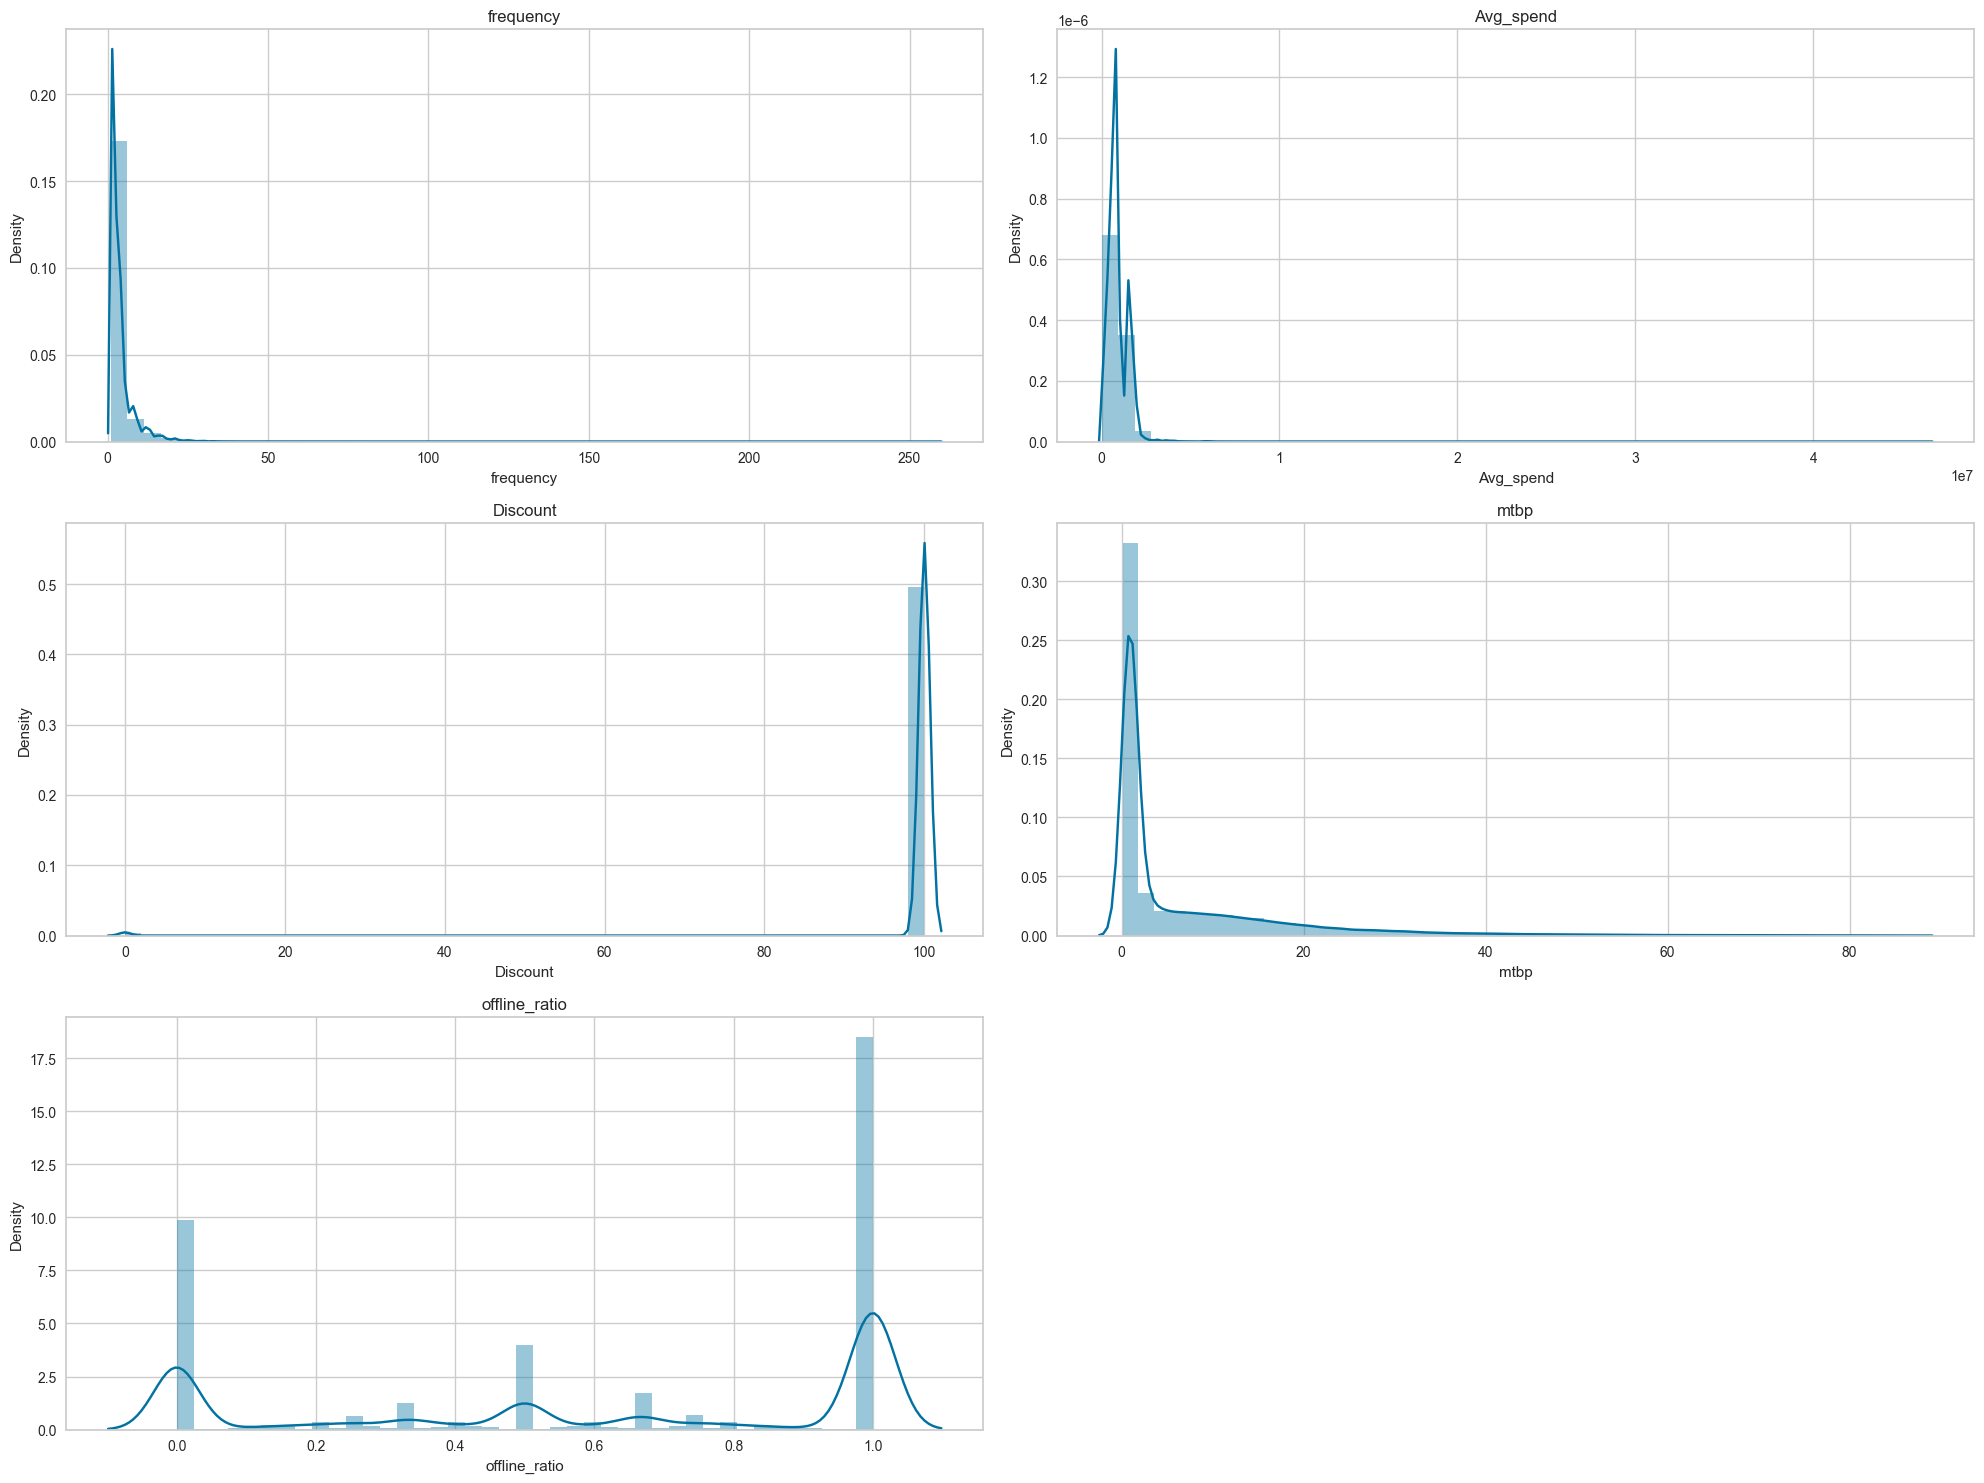

In [60]:
# def normal distribution test
def normality_test(df):
    from scipy.stats import shapiro
    for col in df.columns:
        stat, p = shapiro(df[col]) # shapiro test
        if p <= 0.05:
            print(f'===== {col} =====')
            print('Statistics=%.3f, p=%.3f' % (stat, p))
            print('Probably not Gaussian')

def distribution_plot(df):
    num_cols = len(df.columns)
    num_rows = (num_cols + 2) // 2  # Calculate the number of rows based on the number of columns

    fig, ax = plt.subplots(num_rows, 2, figsize=(20, 5*num_rows))
    for i, col in enumerate(df.columns):
        sns.distplot(df[col], ax=ax[i//2, i%2])
        ax[i//2, i%2].set_title(col)

    # Remove any unused subplots
    if num_cols < num_rows * 2:
        for j in range(num_cols % 2, 2):
            fig.delaxes(ax[num_rows-1, j])
    plt.tight_layout()
    plt.show()

print('*** Normality - Before transform ***')
normality_test(seg)
distribution_plot(seg)

*** Normality - After transform ***


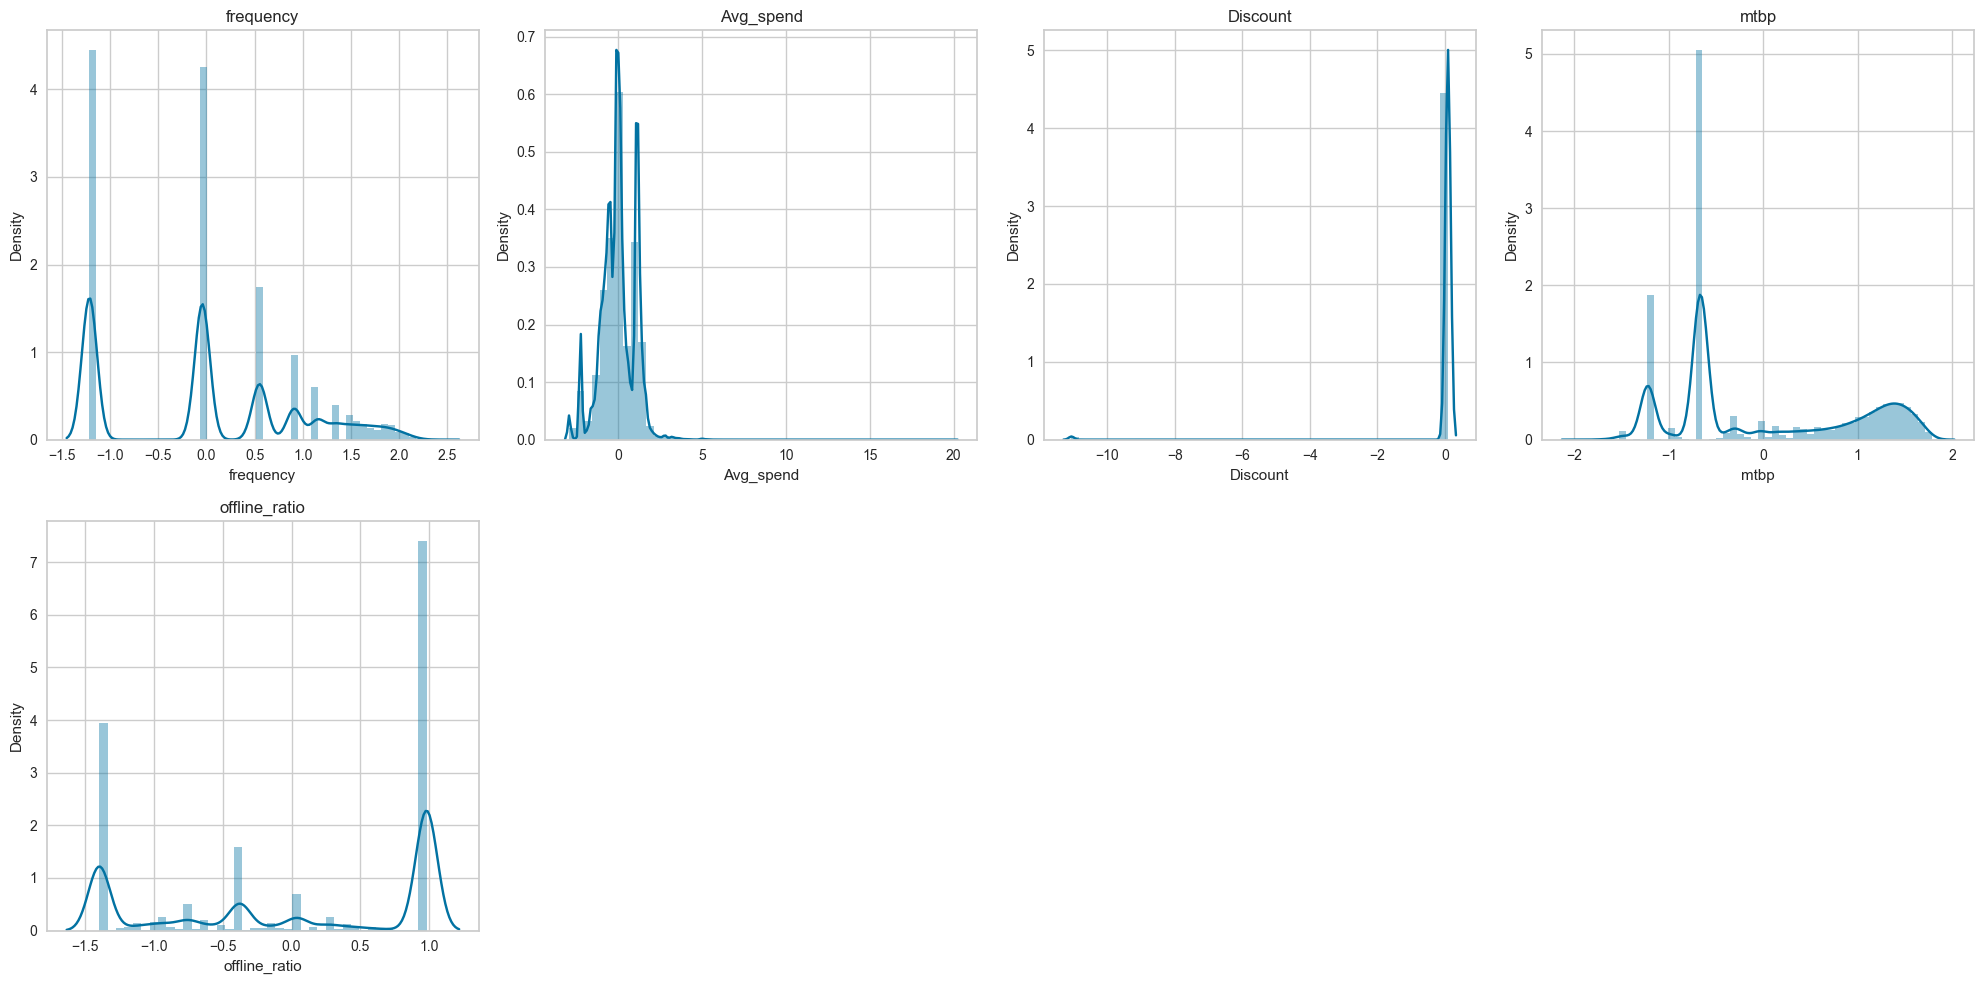

In [36]:
# power transform
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer() #default=’yeo-johnson’
seg_transform = pd.DataFrame(pt.fit_transform(seg))
seg_transform.columns = seg.columns

print('*** Normality - After transform ***')
# normality_test(seg_transform)
distribution_plot(seg_transform)


In [37]:
seg_transform

,frequency,Avg_spend,Discount,mtbp,offline_ratio
0,-0.042848,-0.893901,0.090443,1.555149,-0.375735
1,-0.042848,1.522301,0.090443,1.655157,-1.395506
2,1.771619,-0.881862,0.090443,1.053790,0.199787
3,-1.215923,-0.897699,0.090443,-0.664529,0.979734
4,0.552151,0.031038,0.090443,1.172121,0.039631
...,...,...,...,...,...
325622,2.042651,0.476283,0.090443,1.001214,0.261088
325623,-0.042848,-0.374934,0.090443,1.578884,0.979734
325624,1.928971,-0.655801,0.090443,1.184495,0.979734
325625,-1.215923,-2.235405,0.090443,-0.664529,0.979734


# Elbow Method

Elbow Method to determine the number of clusters to be formed:


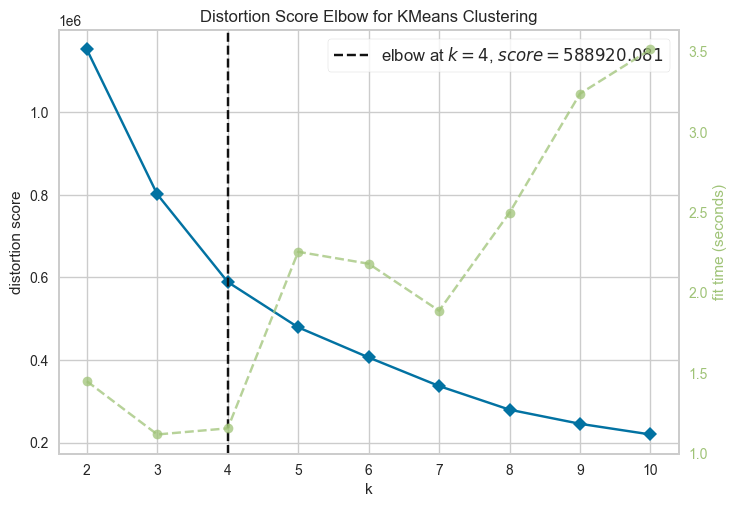

In [38]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(random_state=158), k=10, scoere='calinski_harabasz')
Elbow_M.fit(seg_transform)
Elbow_M.show();

# K-Means

In [39]:
# Initialize and fit the K-means model
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit model and predict clusters
yhat = kmeans.fit_predict(seg_transform)

In [40]:
# create a new column in the scaled dataframe with the cluster labels
seg_kmean = pd.DataFrame(seg, columns=seg.columns)
seg_kmean["Clusters"] = pd.Series(yhat, index=seg_transform.index)
seg_kmean

# # Adding the Clusters feature to the original dataframe.
# seg["Clusters"] = seg_kmean["Clusters"]
# seg.head()

,frequency,Avg_spend,Discount,mtbp,offline_ratio,Clusters
0,2,4.115000e+05,100.0,28.500000,0.500000,2
1,2,1.899000e+06,100.0,42.000000,0.000000,2
2,11,4.162727e+05,100.0,8.545455,0.727273,2
3,1,4.100000e+05,100.0,1.000000,1.000000,1
4,3,8.558333e+05,100.0,10.666667,0.666667,2
...,...,...,...,...,...,...
325622,20,1.125350e+06,100.0,7.800000,0.750000,2
325623,2,6.415000e+05,100.0,31.000000,1.000000,2
325624,15,5.108667e+05,100.0,10.933333,1.000000,2
325625,1,5.000000e+04,100.0,1.000000,1.000000,1


In [41]:
df_segm_analysis = seg_kmean.groupby(["Clusters"]).mean()
df_segm_analysis

,frequency,Avg_spend,Discount,mtbp,offline_ratio
Clusters,,,,,
0,1.401077,1.159516e+06,100.000000,1.076885,0.094668
1,1.679976,9.519915e+05,100.000000,0.955897,0.985748
2,5.663191,8.033886e+05,100.000000,15.621013,0.525744
3,1.068130,9.888342e+02,0.056775,1.038039,1.000000


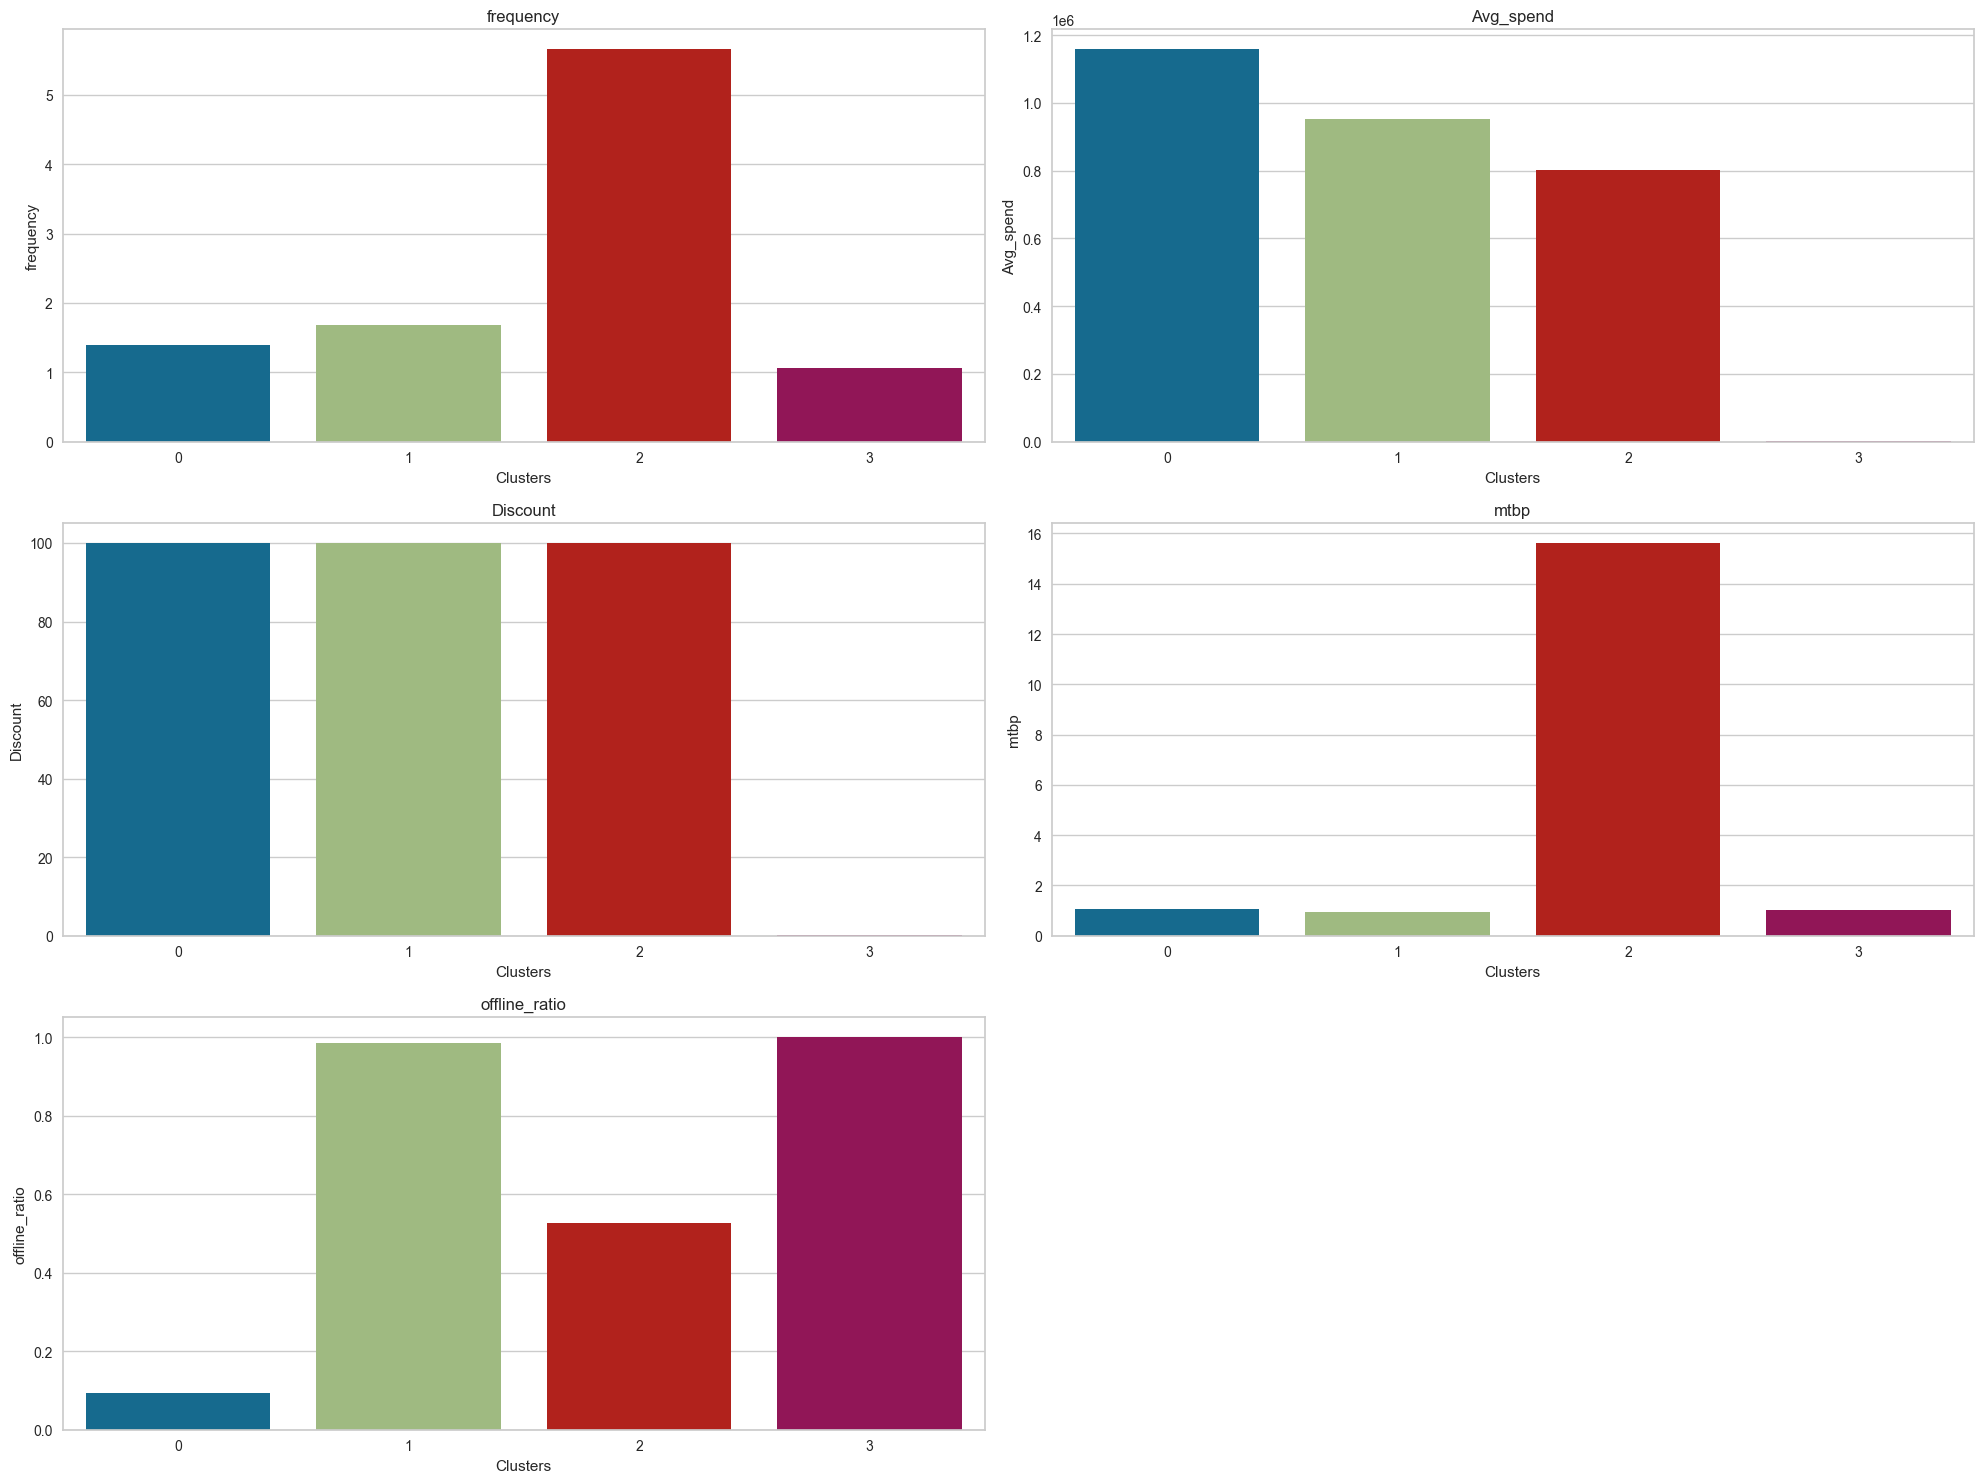

In [42]:
def bar_plot(df):
    # 2 columns
    num_cols = len(df.columns)
    num_rows = (num_cols + 1) // 2  # Calculate the number of rows based on the number of columns

    fig, ax = plt.subplots(num_rows, 2, figsize=(20, 5*num_rows))
    for i, col in enumerate(df.columns):
        sns.barplot(x=df.index, y=df[col], ax=ax[i//2, i%2])
        ax[i//2, i%2].set_title(col)

    # Remove any unused subplots
    if num_cols < num_rows * 2:
        for j in range(num_cols % 2, 2):
            fig.delaxes(ax[num_rows-1, j])
    plt.tight_layout()
    plt.show()
    

bar_plot(df_segm_analysis)

### Labeling

# Principle Component Analysis

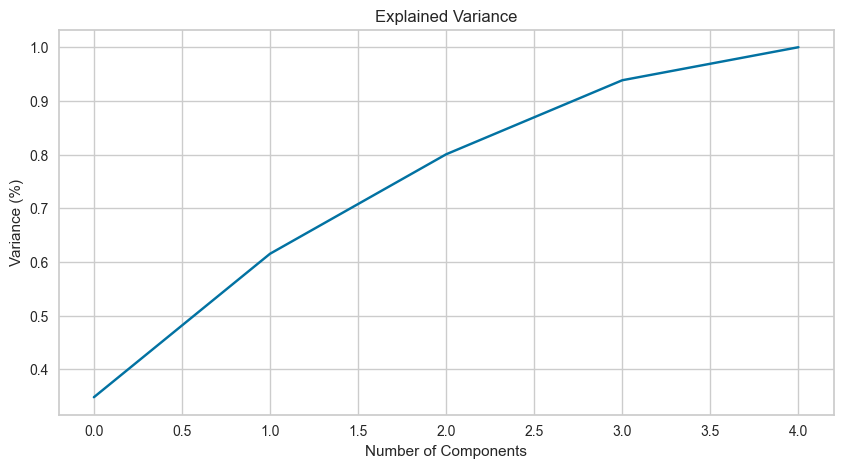

In [44]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(seg_transform)
pca.explained_variance_ratio_

# Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

rule of thumb is to keep at least 60 to 80 percent of the explained variance.
So Let’s keep the first 2 components for our further analysis.

In [45]:
pca = PCA(n_components=2)
pca.fit(seg_transform)
print("explained_variance_ratio_:", pca.explained_variance_ratio_)

PCA_ds = pd.DataFrame(pca.transform(seg_transform), columns=(["PC1","PC2"]))
PCA_ds.describe().T

explained_variance_ratio_: [0.34785133 0.26731165]


,count,mean,std,min,25%,50%,75%,max
PC1,325627.0,1.040414e-16,1.318811,-2.670662,-1.251330,0.367731,1.108774,3.966505
PC2,325627.0,8.379170e-18,1.156098,-9.216141,-0.426122,-0.028289,0.582578,14.261458


,frequency,Avg_spend,Discount,mtbp,offline_ratio
PC-1,-0.671488,0.165874,-0.119550,-0.672655,0.234164
PC-2,-0.119444,0.679654,0.607558,0.042755,-0.390958


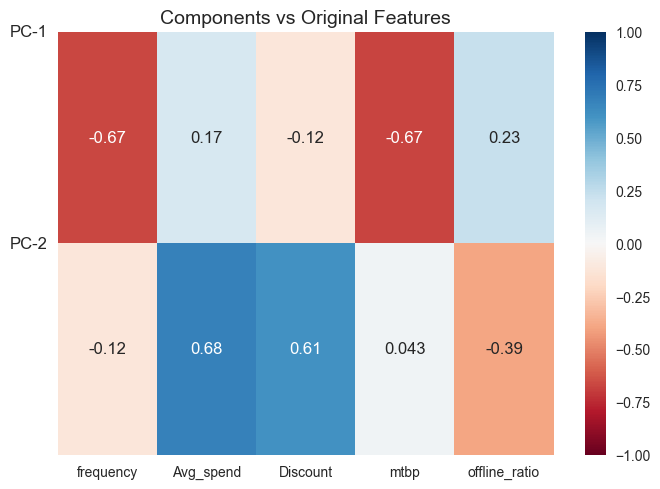

In [46]:
df_pca_comp = pd.DataFrame(pca.components_,columns=seg_transform.columns,index = ['PC-1','PC-2'])
display(df_pca_comp)

# heatmap
sns.heatmap(df_pca_comp,
            vmin = -1,
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([0,1],['PC-1','PC-2'], rotation = 360, fontsize = 12)
plt.title('Components vs Original Features',fontsize = 14)
plt.show()

In [47]:
PCA_ds["Clusters"] = yhat
PCA_ds

,PC1,PC2,Clusters
0,-1.264378,-0.334088,2
1,-1.169658,1.711057,2
2,-2.008765,-0.789073,2
3,1.333177,-0.821388,1
4,-1.155580,0.044714,2
...,...,...,...
325622,-1.915759,0.075408,2
325623,-0.876859,-0.510288,2
325624,-1.982212,-0.953563,2
325625,1.111287,-1.730566,1


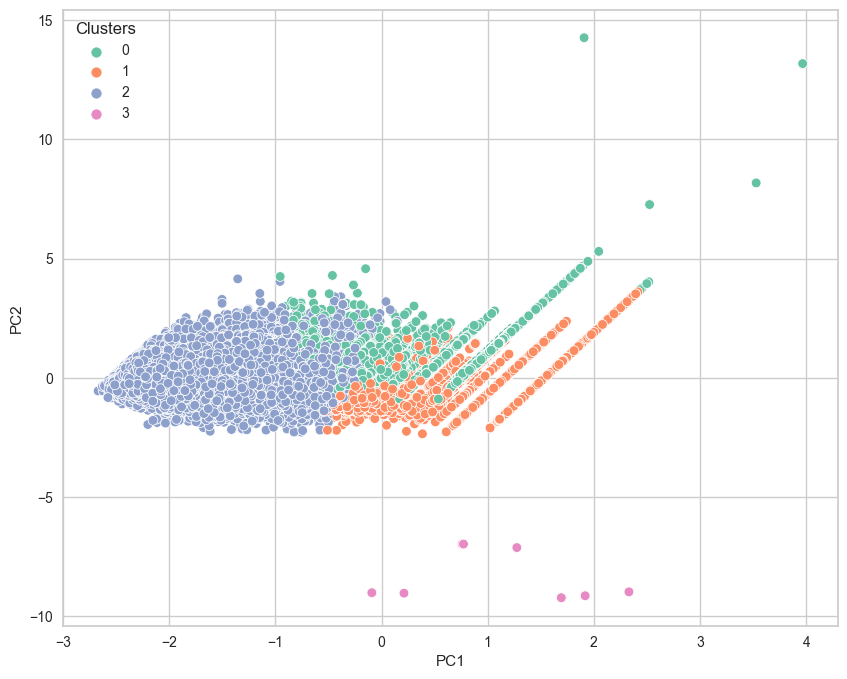

In [48]:
# Plot the clusters on reduced dimension data
plt.figure(figsize=(10,8))
sns.scatterplot(x="PC1", y="PC2", hue="Clusters", data=PCA_ds, palette="Set2")
plt.show()

In [49]:
seg_reslut=pd.concat([features.iloc[:,0:1],seg], axis=1)
seg_reslut.head()

,ent,frequency,Avg_spend,Discount,mtbp,offline_ratio,Clusters
0,8C4ECCCCC3Y,2,4.115000e+05,100.0,28.500000,0.500000,2
1,8CCCCCC4R1F,2,1.899000e+06,100.0,42.000000,0.000000,2
2,BC11JW3U,11,4.162727e+05,100.0,8.545455,0.727273,2
3,BCCCCRE3CZY,1,4.100000e+05,100.0,1.000000,1.000000,1
4,BCCCCREW3WY,3,8.558333e+05,100.0,10.666667,0.666667,2


# Feature Selection

In [51]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split data into train and test sets
X = seg_transform
y = pd.DataFrame(yhat)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
# print(y_train.value_counts(normalize=True))
# print(y_test.value_counts(normalize=True))

In [52]:
rfc = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=1, random_state=42)
boruta_selector.fit(np.array(X), np.array(y))

# Important features
important = list(X.columns[boruta_selector.support_])
print("Important features:", important)

# Tentative features
tentative = list(X.columns[boruta_selector.support_weak_])
print("Tentative features:", tentative)

# Unimportant features
unimportant = list(X.columns[~(boruta_selector.support_ | boruta_selector.support_weak_)])
print("Unimportant features:", unimportant)



Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	0
Important features: ['frequency', 'Avg_spend', 'Discount', 'mtbp', 'offline_ratio']
Tentative features: []
Unimportant features: []


# Feature importance

In [53]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

2    0.403177
1    0.370793
0    0.217915
3    0.008115
dtype: float64
2    0.403172
1    0.370804
0    0.217916
3    0.008107
dtype: float64


In [54]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# Fit the classifier to the training data
rf_classifier.fit(X_train, y_train)
# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)
# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.999800386942235


In [55]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame of feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

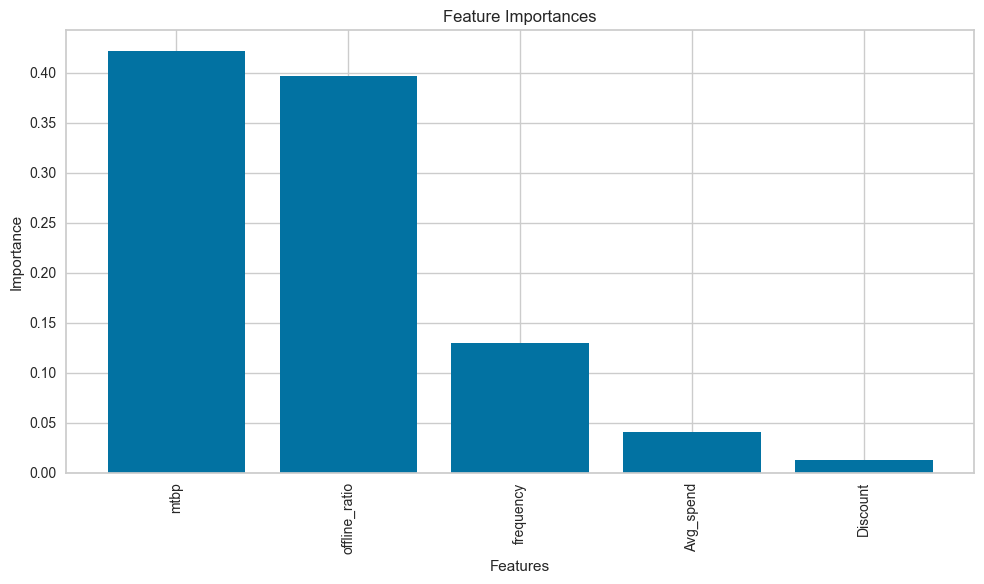

In [56]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

# Final Model

### 1.PCA

In [58]:
# PCA
pca = PCA(n_components=2)
pca.fit(seg_transform)
print("explained_variance_ratio_:", pca.explained_variance_ratio_)
PCA_ds = pd.DataFrame(pca.transform(seg_transform), columns=(["PC1","PC2"]))
PCA_ds.describe().T


explained_variance_ratio_: [0.39399744 0.25882434]


,count,mean,std,min,25%,50%,75%,max
PC1,325627.0,-6.982642e-17,1.537528,-3.780783,-1.351904,-0.395686,1.182338,3.946827
PC2,325627.0,-2.513751e-17,1.246174,-4.169194,-1.044263,0.023593,0.914264,10.452469


Elbow Method to determine the number of clusters to be formed:


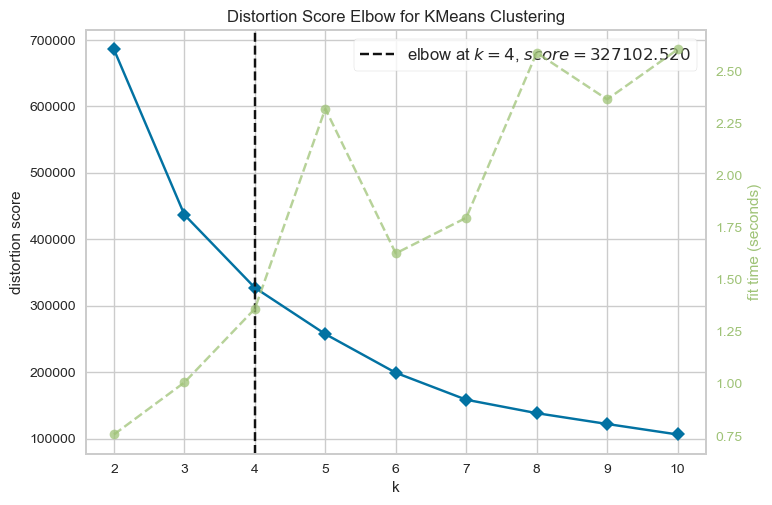

In [59]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(random_state=158), k=10, scoere='calinski_harabasz')
Elbow_M.fit(PCA_ds)
Elbow_M.show();

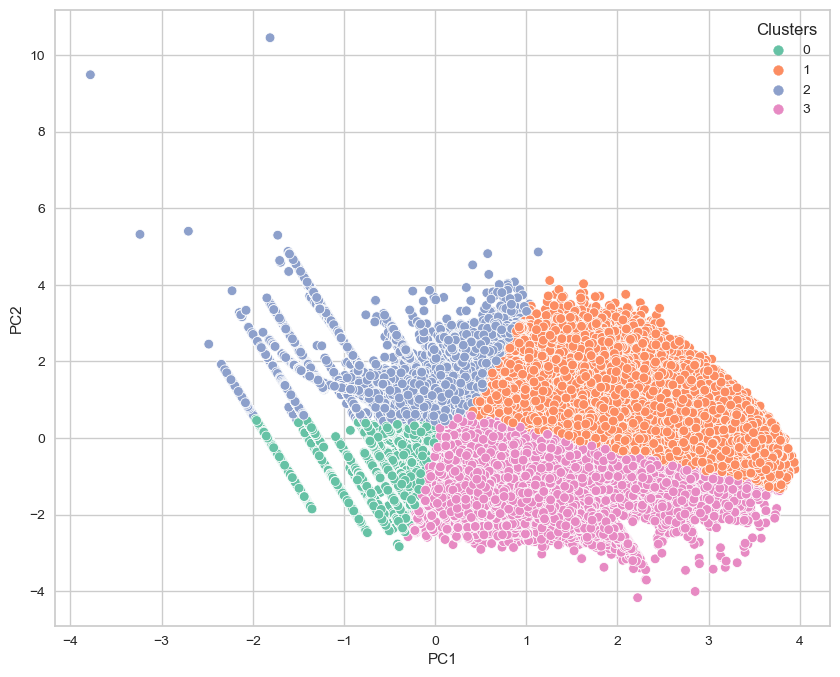

In [60]:
# k-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(PCA_ds)
cluster = kmeans.predict(PCA_ds)
PCA_ds["Clusters"] = cluster

# Plot the clusters on reduced dimension data
plt.figure(figsize=(10,8))
sns.scatterplot(x="PC1", y="PC2", hue="Clusters", data=PCA_ds, palette="Set2")
plt.show()



In [61]:
PCA_ds

,PC1,PC2,Clusters
0,0.907213,-0.329349,3
1,0.484304,1.776711,2
2,2.739481,-1.517903,3
3,-1.600422,-0.899476,0
4,1.148050,-0.398049,3
...,...,...,...
325622,3.584489,-0.029118,1
325623,0.458128,-1.074464,3
325624,2.114825,-2.760702,3
325625,-1.435016,-1.528028,0


In [ ]:
# save model
import pickle
pickle.dump(kmeans, open('kmeans_model_1.pkl', 'wb'))

# load model
kmeans_1 = pickle.load(open('kmeans_model_1.pkl', 'rb'))

,frequency,Avg_spend,Discount,mtbp,trans_type_offline,trans_type_online
Clusters,,,,,,
0,1.575299,8.639680e+05,0.239118,0.921787,1.440639,0.134660
1,6.758290,9.205128e+05,1.776295,18.527510,2.508971,4.249319
2,1.283832,1.405021e+06,3.435378,1.586013,0.159407,1.124425
3,4.429608,6.460979e+05,0.114097,10.923399,3.335915,1.093693


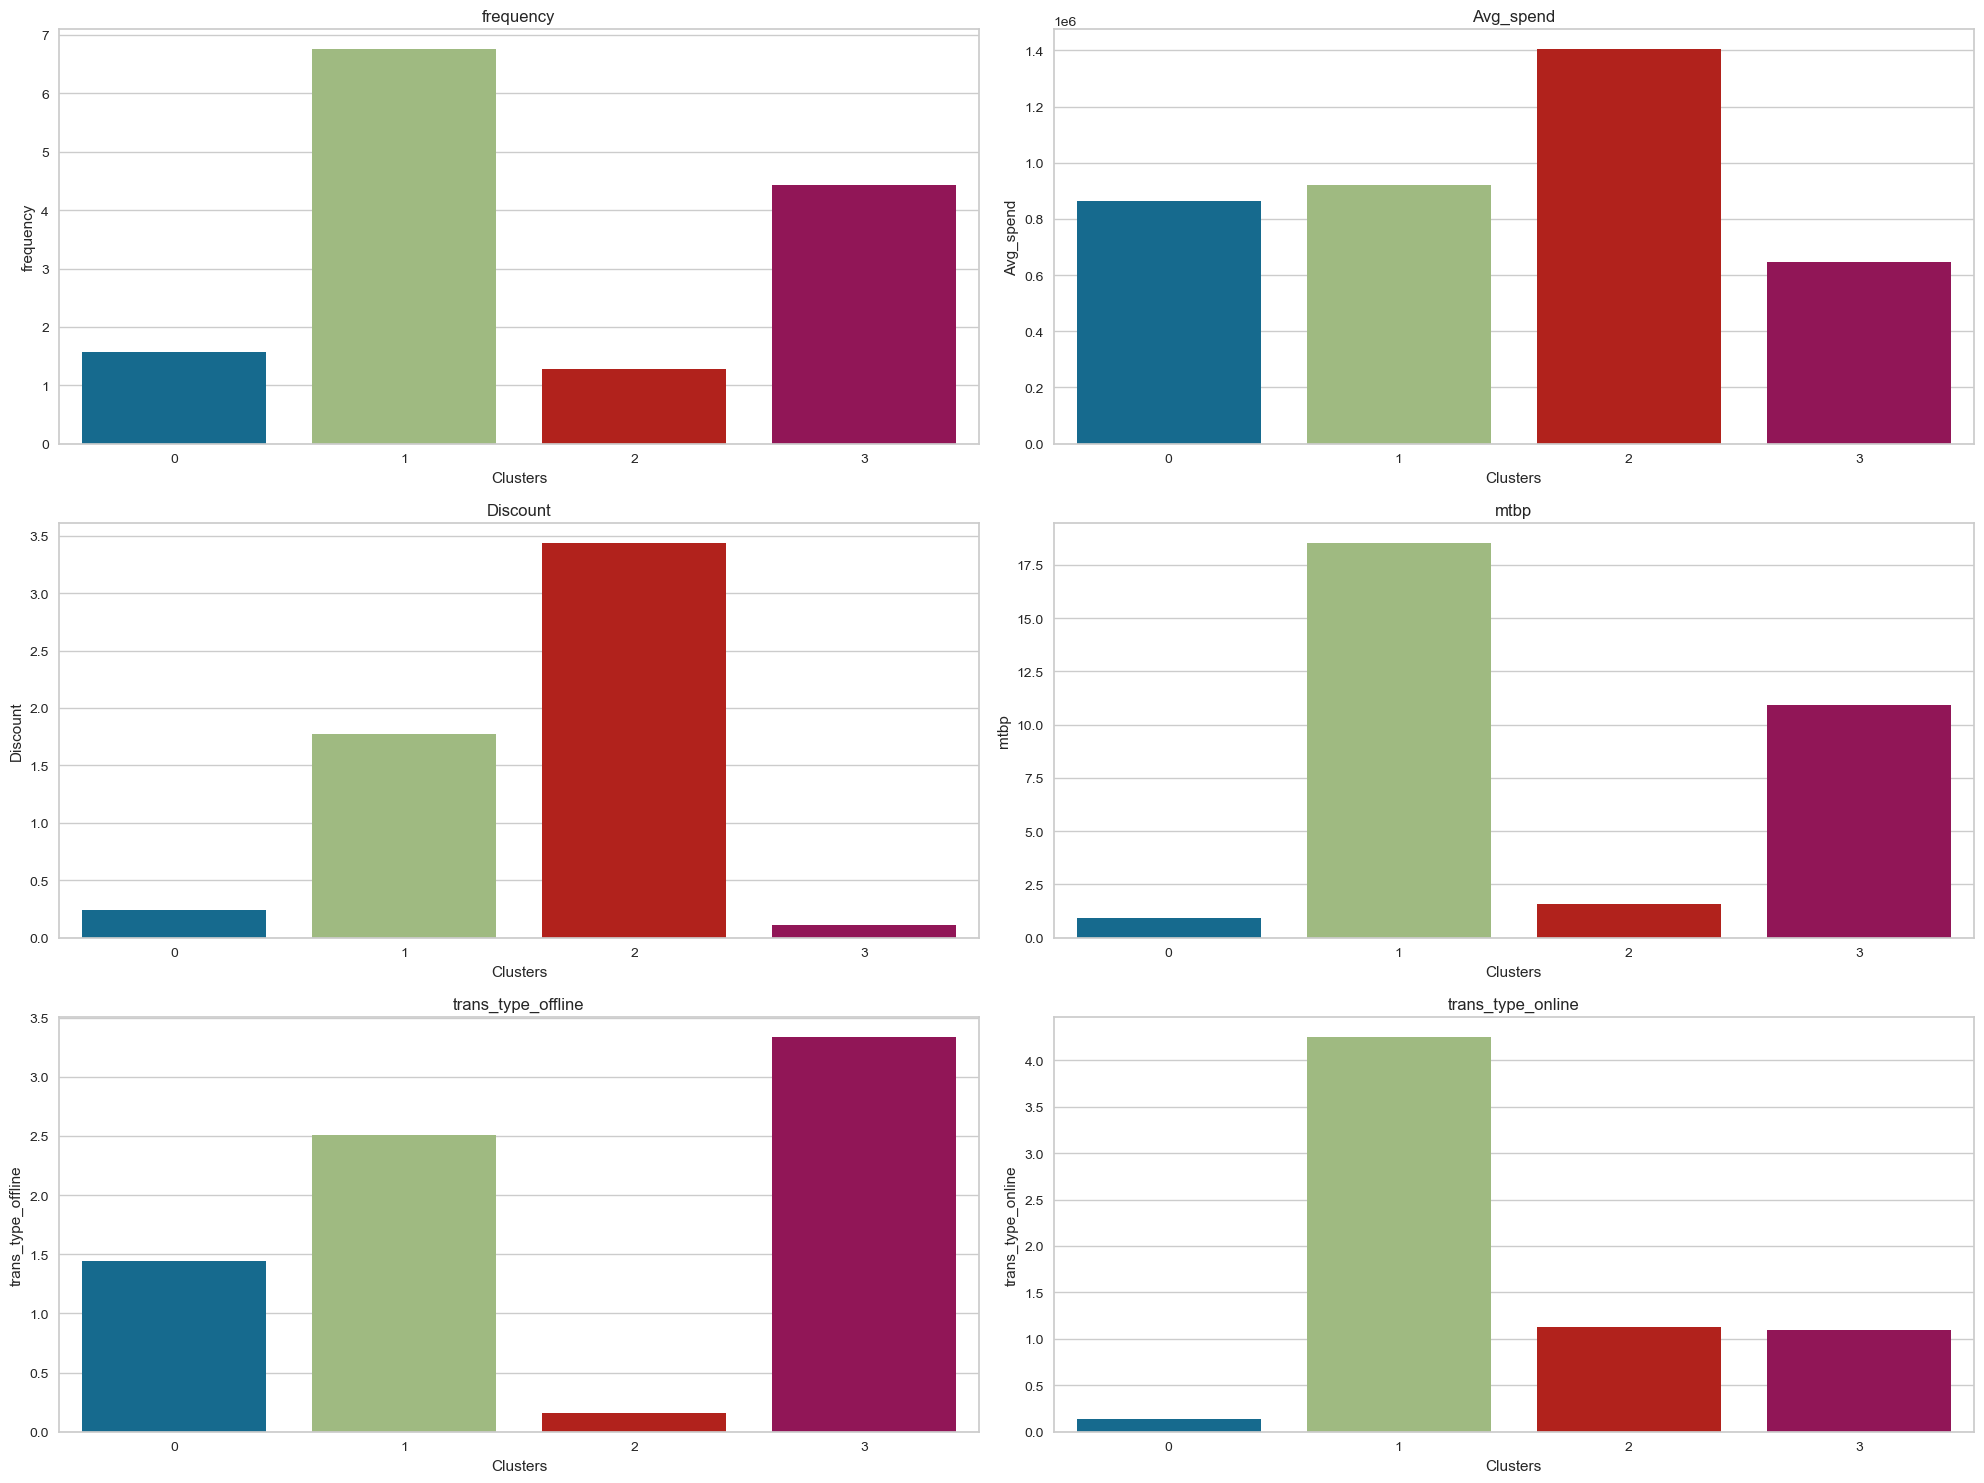

In [62]:
# seg.drop(columns=['Clusters'], inplace=True)
seg_kmean_pca = seg.copy()
seg_kmean_pca["Clusters"] = PCA_ds["Clusters"]

df_seg_kmean_pca_analysis = seg_kmean_pca.groupby(["Clusters"]).mean()
display(df_seg_kmean_pca_analysis)
bar_plot(df_seg_kmean_pca_analysis)

In [ ]:
df_seg_kmean_pca_analysis.to_csv('df_seg_kmean_pca_analysis.csv')

In [ ]:
# feature importance
X_fea_imp = seg_transform
y_fea_imp = pd.DataFrame(PCA_ds["Clusters"])

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fea_imp, y_fea_imp, test_size=0.2, random_state=42, stratify = y_fea_imp)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

### Random Forest classifier ###
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# Fit the classifier to the training data
rf_classifier.fit(X_train, y_train)
# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)
# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

### Get feature importances ###
feature_importances = rf_classifier.feature_importances_
# Create a DataFrame of feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

#### Plot feature importances ####
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

### 2.Autoencoder

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_autoencoder(input_dim, encoding_dim):
    # Encoder
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)

    # Decoder
    decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

    # Autoencoder
    autoencoder = models.Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Encoder (separate model for dimension reduction)
    encoder = models.Model(input_layer, encoded)

    return autoencoder, encoder

def reduce_dimension(data, encoding_dim, epochs=50, batch_size=32):
    autoencoder, encoder = build_autoencoder(data.shape[1], encoding_dim)
    autoencoder.fit(data, data, epochs=epochs, batch_size=batch_size, verbose=0)
    reduced_data = encoder.predict(data)
    # Save the encoder model
    encoder.save('encoder_model.h5')
    return reduced_data

X = seg_transform.copy()
reduced_X = reduce_dimension(X, encoding_dim=2, epochs=100, batch_size=64)
print("Original shape:", X.shape)
print("Reduced shape:", reduced_X.shape)

In [ ]:
auto_df = pd.DataFrame(reduced_X, columns=(["Auto1","Auto2"]))
auto_df.describe().T

In [ ]:
auto_df

In [ ]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(random_state=158), k=10, scoere='calinski_harabasz')
Elbow_M.fit(auto_df)
Elbow_M.show();

In [ ]:
# k-means clustering
kmeans_auto = KMeans(n_clusters=4, random_state=42)
kmeans_auto.fit(auto_df)
cluster = kmeans_auto.predict(auto_df)
auto_df["Clusters"] = cluster

# Plot the clusters on reduced dimension data
plt.figure(figsize=(10,8))
sns.scatterplot(x="Auto1", y="Auto2", hue="Clusters", data=auto_df, palette="Set2", legend='full')
plt.show()



In [ ]:
# save model
import pickle
pickle.dump(kmeans_auto, open('kmeans_model_2.pkl', 'wb'))

# load model
kmeans_2 = pickle.load(open('kmeans_model_2.pkl', 'rb'))


In [ ]:
# seg.drop(columns=['Clusters'], inplace=True)
seg_kmean_auto = seg.copy()
seg_kmean_auto["Clusters"] = auto_df["Clusters"]

df_seg_kmean_auto_analysis = seg_kmean_auto.groupby(["Clusters"]).mean()
display(df_seg_kmean_auto_analysis)
bar_plot(df_seg_kmean_auto_analysis)

In [ ]:
df_seg_kmean_auto_analysis.to_csv('df_seg_kmean_auto_analysis.csv')

In [66]:
seg.drop(columns=['Clusters'], inplace=True)

In [67]:
seg

,frequency,Avg_spend,Discount,mtbp,trans_type_offline,trans_type_online
0,2,4.115000e+05,0.000000,28.500000,1,1
1,2,1.899000e+06,0.000000,42.000000,0,2
2,11,4.162727e+05,0.000000,8.545455,8,3
3,1,4.100000e+05,0.000000,1.000000,1,0
4,3,8.558333e+05,0.000000,10.666667,2,1
...,...,...,...,...,...,...
325622,20,1.125350e+06,1.521679,7.800000,15,5
325623,2,6.415000e+05,0.000000,31.000000,2,0
325624,15,5.108667e+05,0.000000,10.933333,15,0
325625,1,5.000000e+04,0.000000,1.000000,1,0


In [65]:
seg_transform

,frequency,Avg_spend,Discount,mtbp,trans_type_offline,trans_type_online
0,-0.042848,-0.893901,-0.595228,1.555149,-0.154797,0.417359
1,-0.042848,1.522301,-0.595228,1.655157,-1.458681,0.962281
2,1.771619,-0.881862,-0.595228,1.053790,1.982462,1.256679
3,-1.215923,-0.897699,-0.595228,-0.664529,-0.154797,-1.024244
4,0.552151,0.031038,-0.595228,1.172121,0.505866,0.417359
...,...,...,...,...,...,...
325622,2.042651,0.476283,1.659480,1.001214,2.603072,1.573940
325623,-0.042848,-0.374934,-0.595228,1.578884,0.505866,-1.024244
325624,1.928971,-0.655801,-0.595228,1.184495,2.603072,-1.024244
325625,-1.215923,-2.235405,-0.595228,-0.664529,-0.154797,-1.024244


In [68]:
seg.to_parquet('train_data_21.parquet')

In [69]:
seg_transform.to_parquet('train_data_21_transform.parquet')

In [ ]:
# feature importance
X_fea_imp = seg_transform
y_fea_imp = pd.DataFrame(auto_df["Clusters"])

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fea_imp, y_fea_imp, test_size=0.2, random_state=42, stratify = y_fea_imp)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

### Random Forest classifier ###
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# Fit the classifier to the training data
rf_classifier.fit(X_train, y_train)
# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)
# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

### Get feature importances ###
feature_importances = rf_classifier.feature_importances_
# Create a DataFrame of feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

#### Plot feature importances ####
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()